> This is a rework of my task during Computer Vision class in 2022.

> Goal(s):
- to enhance the contrast of selected image to match with the contrast of a reference image using histogram matching method.

# Import Library

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Image Preparation

In [2]:
def show_img(img, title, cmap=None):
  plt.imshow(img, cmap=cmap)
  plt.title(title)
  plt.axis('off')

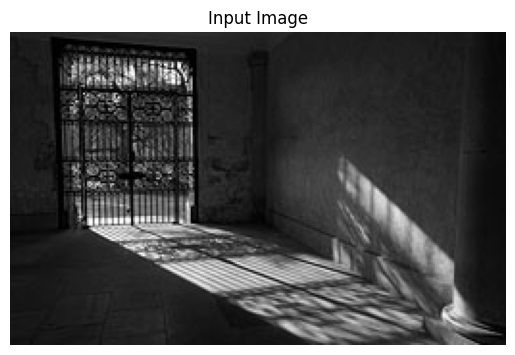

In [3]:
img = cv2.imread('dataset/contrast-enhancement_2/input_image.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
show_img(img, 'Input Image', 'gray')

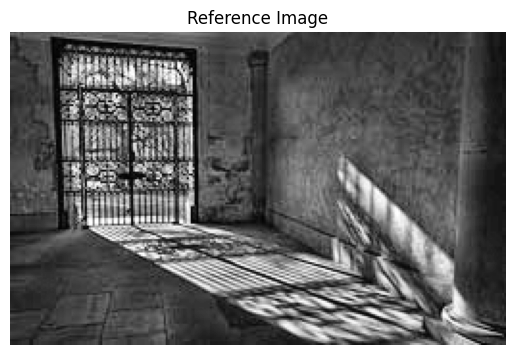

In [4]:
img_ref = cv2.imread('dataset/contrast-enhancement_2/reference_image.jpg')
img_ref = cv2.cvtColor(img_ref, cv2.COLOR_BGR2GRAY)
show_img(img_ref, 'Reference Image', 'gray')

# Histogram of Original Images

> The function to generate the histogram of original image by counting its intensity from each image.

In [5]:
def generate_hist(img, title):
  intensityCtr = np.zeros(256, dtype=int)
  h = img.shape[0]
  w = img.shape[1]
  for i in range(h):
    for j in range(w):
      intensityCtr[img[i][j]] += 1
  plt.plot(intensityCtr, 'g', label='intensity')
  plt.legend(loc='upper right')
  plt.xlabel('Intensity')
  plt.ylabel('Quantity')
  plt.title(title)
  return intensityCtr

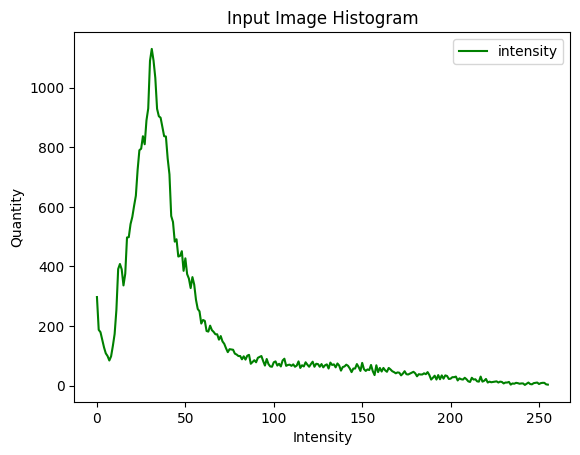

In [6]:
hist = generate_hist(img, 'Input Image Histogram')

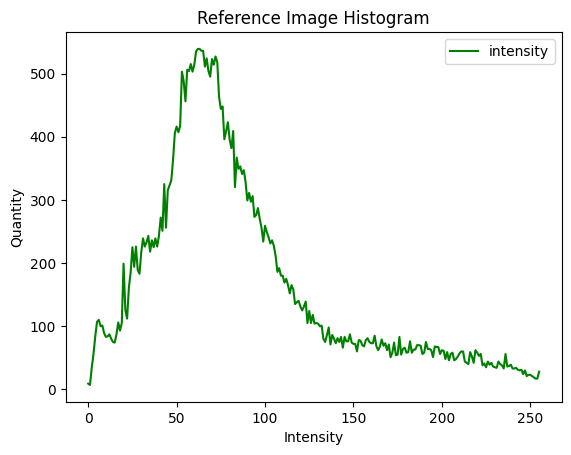

In [7]:
hist_ref = generate_hist(img_ref, 'Reference Image Histogram')

# Equalize Histogram

> The function to equalize each image's histogram is based on this table column names:

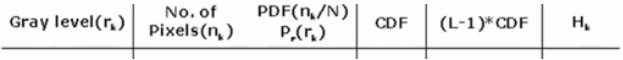

> PDF (Probability Density Function) represents the probability of each gray level (intensity value) occurring in the image. In contrast, CDF (Cumulative Distribution Function) represents the cumulative probability of all gray levels up to and including the current level.

In [8]:
def equalize_hist(hist, title):
  L = hist.shape[0]
  N = np.sum(hist)
  pdf = np.zeros(L, dtype=float)
  cdf = np.zeros(L, dtype=float)
  equalizeCtr = np.zeros(L, dtype=float)
  H = np.zeros(L, dtype=int)
  
  for gray_level in range(L):
    pdf[gray_level] = hist[gray_level] / N
    if (gray_level == 0):
      cdf[gray_level] = pdf[gray_level]
    else:
      cdf[gray_level] = pdf[gray_level] + cdf[gray_level-1]
    equalizeCtr[gray_level] = (L - 1) * cdf[gray_level]
    H[gray_level] = int(np.round(equalizeCtr[gray_level]))
  
  eq_hist = pd.DataFrame({
    'gray level': np.arange(L),
    'no. of pixels': hist,
    'pdf': pdf,
    'cdf': cdf,
    '(L-1) * cdf': equalizeCtr,
    'H': H
  })
  
  plt.plot(H, 'g', label='intensity')
  plt.legend(loc='upper right')
  plt.xlabel('Intensity')
  plt.ylabel('Quantity')
  plt.title(title)
  return eq_hist

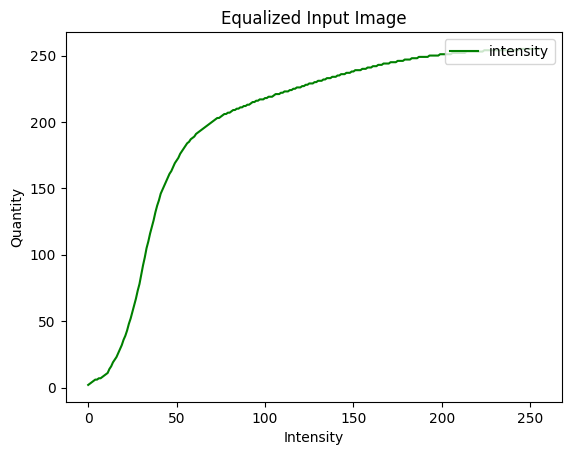

In [9]:
eq_hist = equalize_hist(hist, 'Equalized Input Image')

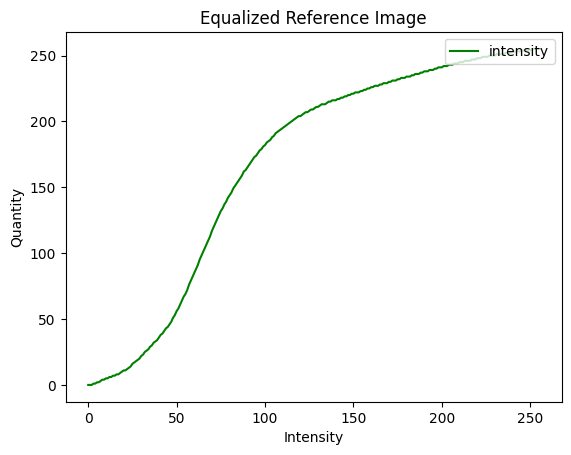

In [10]:
eq_hist_ref = equalize_hist(hist_ref, 'Equalized Reference Image')

> The table below shows how the calculations are performed to generate the equalized histogram result.

In [11]:
eq_hist.head()

,gray level,no. of pixels,pdf,cdf,(L-1) * cdf,H
0,0,297,0.007062,0.007062,1.800899,2
1,1,187,0.004447,0.011509,2.934798,3
2,2,179,0.004256,0.015765,4.020188,4
3,3,154,0.003662,0.019427,4.953988,5
4,4,128,0.003044,0.022471,5.730133,6


In [12]:
eq_hist_ref.head()

,gray level,no. of pixels,pdf,cdf,(L-1) * cdf,H
0,0,9,0.000214,0.000214,0.054573,0
1,1,7,0.000166,0.000380,0.097018,0
2,2,34,0.000808,0.001189,0.303182,0
3,3,56,0.001332,0.002521,0.642745,1
4,4,84,0.001997,0.004518,1.152090,1


# Histogram Matching

> The function to do the histogram matching from the input image equalized histogram to reference image equalized histogram.

In [13]:
def find_val(val, eq_hist_ref, ctr):
  gray_level = np.where(eq_hist_ref == val)[0]
  if len(gray_level) == 0:
    gray_level = np.where(eq_hist_ref == val + ctr)[0]
    if len(gray_level) == 0:
      gray_level = np.where(eq_hist_ref == val - ctr)[0]
      if len(gray_level) == 0:
        gray_level = find_val(val, eq_hist_ref, ctr + 1)

  key = gray_level[0]
  return key

In [14]:
def match_hist(eq_hist, eq_hist_ref, title):
  L = eq_hist.shape[0]
  mappingCtr = np.zeros(L, dtype=int)
  for i in range(L):
    mappingCtr[i] = find_val(eq_hist[i], eq_hist_ref, 1)
  
  plt.plot(mappingCtr, 'g', label='intensity')
  plt.xlabel('Intensity')
  plt.ylabel('Quantity')
  plt.title(title)
  return mappingCtr

> Below are the result (histogram matching) generated.

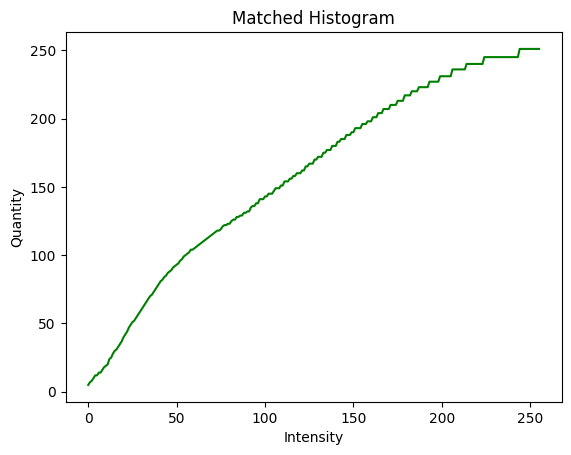

In [15]:
map_hist = match_hist(eq_hist.iloc[:, 5], eq_hist_ref.iloc[:, 5], 'Matched Histogram')

# Histogram Mapping

> The function to generate the input image based on the finished mapping.

In [16]:
def mapping(img, map_hist):
  res_img = img.copy()
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      res_img[i][j] = map_hist[img[i][j]]
  return res_img

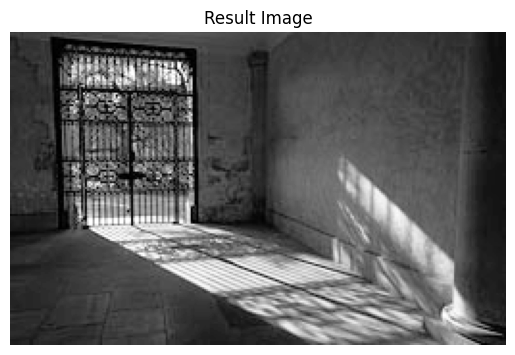

In [17]:
res_img = mapping(img, map_hist)
show_img(res_img, 'Result Image', 'gray')

# Result

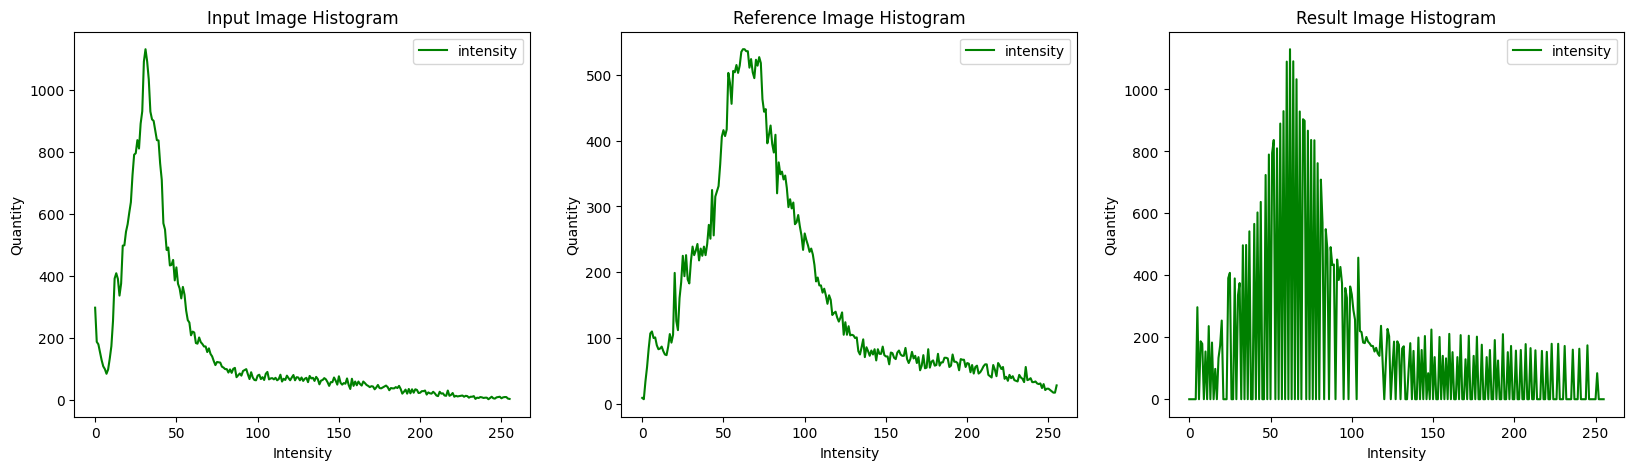

In [18]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
_ = generate_hist(img, 'Input Image Histogram')
plt.subplot(1, 3, 2)
_ = generate_hist(img_ref, 'Reference Image Histogram')
plt.subplot(1, 3, 3)
_ = generate_hist(res_img, 'Result Image Histogram')

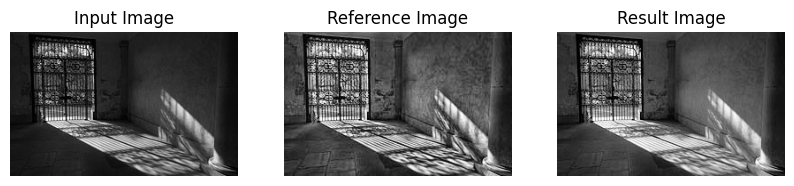

In [19]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
show_img(img, 'Input Image', 'gray')
plt.subplot(1, 3, 2)
show_img(img_ref, 'Reference Image', 'gray')
plt.subplot(1, 3, 3)
show_img(res_img, 'Result Image', 'gray')